# 한국어 텍스트 감정 분석(sentiment analysis)

## 학습 목표 
1. 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
2. RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
3. 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
4. IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.



#### 프로젝트 평가 기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
    - 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## 1. 데이터 준비와 확인

#### 사용된 말뭉치(corpus) 셋 :  Naver sentiment movie corpus 
(https://github.com/e9t/nsmc)
- 데이터 설명
    - id : 네이버 리뷰 아이디, document : 실제 리뷰, label: 감성(0:부정, 1:긍정)
    - 모든 리뷰는 140자 미만
    - 총 200K 리뷰
    - 100K 부정적인 평점(~ 4점), 100K 긍정적인 평점(9~10점), 중간 평점 제외 

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [3]:
len(train_data)

150000

In [4]:
len(test_data)

50000

## 2. 데이터로더 구성

- 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공
- nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일이므로 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 봐야 함, data_loader 안에서는 다음을 수행

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴


In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 1. 데이터의 중복 제거 
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 3. 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 4. 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
# 텍스트 스트링을 사전 인덱스 스트링으로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
len(index_to_word)

10000

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [10]:
print(get_decoded_sentence(X_train[100], index_to_word))
print('라벨: ', y_train[100])  # 101번째 리뷰데이터의 라벨

<UNK> 작화 , <UNK> 하나 카 나 연기 해 줘서 더 대박 였 다 .
라벨:  1


## 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [11]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
# 필요 라이브러리 import 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

### padding 작업
- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미침
- 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적 **'pre'가 훨씬 유리**

In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

In [14]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.
- validation set 20%로 세팅 

In [15]:
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [16]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 41)
(30000,)
(116182, 41)
(116182,)


## 5. 모델 설계 및 훈련 개시
### 5-1. 1-D CNN
- 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용
- CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [18]:
model_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_cnn = model_cnn.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
227/227 [==============================] - 5s 8ms/step - loss: 0.5191 - accuracy: 0.7637 - val_loss: 0.3559 - val_accuracy: 0.8470
Epoch 2/5
227/227 [==============================] - 1s 6ms/step - loss: 0.3145 - accuracy: 0.8671 - val_loss: 0.3302 - val_accuracy: 0.8569
Epoch 3/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2518 - accuracy: 0.8988 - val_loss: 0.3365 - val_accuracy: 0.8580
Epoch 4/5
227/227 [==============================] - 1s 6ms/step - loss: 0.1866 - accuracy: 0.9305 - val_loss: 0.3723 - val_accuracy: 0.8526
Epoch 5/5
227/227 [==============================] - 1s 6ms/step - loss: 0.1242 - accuracy: 0.9579 - val_loss: 0.4397 - val_accuracy: 0.8474


In [19]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4566 - accuracy: 0.8415
[0.4565587043762207, 0.841548502445221]


### 5-2. GlobalMaxPooling1D
- 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

In [20]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_GMP.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_cnn = model_GMP.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
227/227 [==============================] - 1s 5ms/step - loss: 0.6890 - accuracy: 0.5422 - val_loss: 0.6868 - val_accuracy: 0.5463
Epoch 2/5
227/227 [==============================] - 1s 4ms/step - loss: 0.6875 - accuracy: 0.5471 - val_loss: 0.6864 - val_accuracy: 0.5483
Epoch 3/5
227/227 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.5472 - val_loss: 0.6863 - val_accuracy: 0.5474
Epoch 4/5
227/227 [==============================] - 1s 4ms/step - loss: 0.6870 - accuracy: 0.5475 - val_loss: 0.6867 - val_accuracy: 0.5490
Epoch 5/5
227/227 [==============================] - 1s 4ms/step - loss: 0.6868 - accuracy: 0.5489 - val_loss: 0.6864 - val_accuracy: 0.5474


In [22]:
results = model_GMP.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.6875 - accuracy: 0.5440
[0.6875255703926086, 0.5440120697021484]


### 5-3. LSTM 모델 

In [23]:
vocab_size = 10000
word_vector_dim = 200

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dropout(0.5))
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM1 = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 4s 9ms/step - loss: 0.4501 - accuracy: 0.8034 - val_loss: 0.3445 - val_accuracy: 0.8511
Epoch 2/7
227/227 [==============================] - 2s 7ms/step - loss: 0.3338 - accuracy: 0.8624 - val_loss: 0.3378 - val_accuracy: 0.8519
Epoch 3/7
227/227 [==============================] - 1s 7ms/step - loss: 0.3001 - accuracy: 0.8774 - val_loss: 0.3385 - val_accuracy: 0.8551
Epoch 4/7
227/227 [==============================] - 2s 7ms/step - loss: 0.2743 - accuracy: 0.8873 - val_loss: 0.3523 - val_accuracy: 0.8542
Epoch 5/7
227/227 [==============================] - 2s 7ms/step - loss: 0.2516 - accuracy: 0.8980 - val_loss: 0.3687 - val_accuracy: 0.8536
Epoch 6/7
227/227 [==============================] - 1s 7ms/step - loss: 0.2342 - accuracy: 0.9044 - val_loss: 0.3893 - val_accuracy: 0.8526
Epoch 7/7
227/227 [==============================] - 2s 7ms/step - loss: 0.2187 - accuracy: 0.9105 - val_loss: 0.4000 - val_accuracy: 0.8524


In [25]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4055 - accuracy: 0.8468
[0.4054844379425049, 0.8468376994132996]


## 6. Loss, Accuracy 그래프 시각화

In [26]:
history_dict = history_LSTM1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


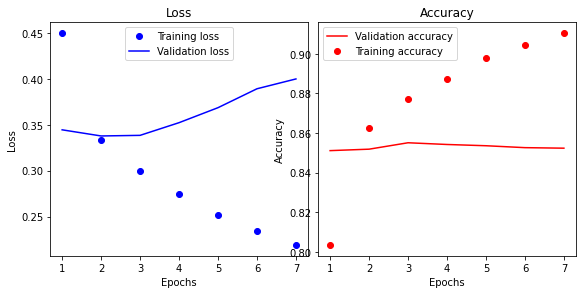

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend(loc='upper center')
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

## 7. 학습된 Embedding 레이어 분석

In [28]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [29]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
import gensim

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['안녕']
vector

array([ 0.08883806, -0.09184099,  0.04583429, -0.10395797, -0.01493828,
        0.02075003, -0.01844141, -0.05334135,  0.0452558 ,  0.07126295,
        0.00147492, -0.01657622,  0.00405663, -0.01935668, -0.09182619,
       -0.02369577,  0.03914787,  0.02553529,  0.01519068,  0.0146342 ,
        0.00541177, -0.01312086, -0.03659642,  0.01870177,  0.0021624 ,
       -0.08205276, -0.04011701,  0.02240903, -0.02282909, -0.06522453,
       -0.07335952, -0.0396368 ,  0.01789493, -0.00231797, -0.0708558 ,
        0.02220414,  0.03011447,  0.00764453,  0.01051149, -0.0788481 ,
        0.06153232, -0.0432262 , -0.09515183, -0.07071853, -0.01724233,
        0.05243582, -0.05316149, -0.01695387,  0.03033847,  0.03980321,
       -0.03702838, -0.0296776 , -0.03436   ,  0.01939282, -0.00749454,
       -0.11819526,  0.01027503,  0.04165385, -0.05994166,  0.02791183,
       -0.04129172, -0.05148831,  0.02145062, -0.05822638, -0.00463714,
       -0.07175741,  0.06065438,  0.01966364,  0.01939682,  0.09

In [32]:
word_vectors.similar_by_word("액션")

[('무능', 0.55491042137146),
 ('놓치', 0.5430845022201538),
 ('귀여워서', 0.542033314704895),
 ('떠서', 0.541975200176239),
 ('명복', 0.5417341589927673),
 ('그렇지만', 0.53937828540802),
 ('토미', 0.5351923108100891),
 ('그레이스', 0.529245138168335),
 ('긴말', 0.5262212753295898),
 ('블랙', 0.5246603488922119)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
#### 한국어 Word2Vec 경로 : https://github.com/Kyubyong/wordvectors
- 위의 경로에서 Korean(w) > ko.bin 파일 다운 받아서 사용 
### gensim 버전 중요! 
- gensim 버전이 4.0.X 이상일 경우 vocab라는 코드가 gensim 패키지 안에서 사라졌기 때문에 3.8.X 버전으로 세팅

In [33]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['안녕']
vector.shape    

/tmp/ipykernel_4097/3784114315.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['안녕']


(200,)

In [34]:
# !pip install gensim==3.8.3     # 3.8.X 버전이여야 함
gensim.__version__

'3.8.3'

In [35]:
word2vec.similar_by_word("액션")

/tmp/ipykernel_4097/346242310.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("액션")


[('슈팅', 0.8099634647369385),
 ('어드벤처', 0.7256604433059692),
 ('게임', 0.6752271056175232),
 ('아케이드', 0.6547571420669556),
 ('퍼즐', 0.6438050270080566),
 ('격투', 0.6437793970108032),
 ('퍼펙트', 0.618266761302948),
 ('오리지널', 0.6145720481872559),
 ('미소녀', 0.6113677024841309),
 ('판타지', 0.6075881719589233)]

## 9. 앞선 모델 다시 돌리기 

In [36]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4097/903695008.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4097/903695008.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


### 1-D CNN

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200# 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [38]:
model_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_cnn = model_cnn.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
227/227 [==============================] - 2s 7ms/step - loss: 0.5603 - accuracy: 0.7003 - val_loss: 0.4361 - val_accuracy: 0.7977
Epoch 2/5
227/227 [==============================] - 1s 6ms/step - loss: 0.3931 - accuracy: 0.8245 - val_loss: 0.3707 - val_accuracy: 0.8366
Epoch 3/5
227/227 [==============================] - 1s 6ms/step - loss: 0.3310 - accuracy: 0.8586 - val_loss: 0.3627 - val_accuracy: 0.8405
Epoch 4/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2978 - accuracy: 0.8748 - val_loss: 0.3553 - val_accuracy: 0.8466
Epoch 5/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2703 - accuracy: 0.8886 - val_loss: 0.3583 - val_accuracy: 0.8469


In [39]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3715 - accuracy: 0.8434
[0.3714892864227295, 0.843399703502655]


### GlobalMaxPooling1D

In [40]:
model_GMP = tf.keras.Sequential()
model_GMP.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
                        
model_GMP.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP.add(tf.keras.layers.Dense(8, activation='relu'))
model_GMP.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_GMP.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history_cnn = model_GMP.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
227/227 [==============================] - 2s 5ms/step - loss: 0.7443 - accuracy: 0.5525 - val_loss: 0.6346 - val_accuracy: 0.6431
Epoch 2/5
227/227 [==============================] - 1s 4ms/step - loss: 0.5915 - accuracy: 0.6917 - val_loss: 0.5543 - val_accuracy: 0.7243
Epoch 3/5
227/227 [==============================] - 1s 5ms/step - loss: 0.5232 - accuracy: 0.7458 - val_loss: 0.5045 - val_accuracy: 0.7547
Epoch 4/5
227/227 [==============================] - 1s 4ms/step - loss: 0.4730 - accuracy: 0.7773 - val_loss: 0.4626 - val_accuracy: 0.7792
Epoch 5/5
227/227 [==============================] - 1s 4ms/step - loss: 0.4355 - accuracy: 0.7995 - val_loss: 0.4392 - val_accuracy: 0.7939


In [42]:
results = model_GMP.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4490 - accuracy: 0.7899
[0.44904085993766785, 0.7898773550987244]


### LSTM

In [43]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                       embeddings_initializer=Constant(embedding_matrix),
                                        input_length=maxlen,
                                        trainable=True))
model_lstm.add(keras.layers.LSTM(16))
model_lstm.add(keras.layers.Dropout(0.5))
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_LSTM = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 3s 8ms/step - loss: 0.5697 - accuracy: 0.6974 - val_loss: 0.4125 - val_accuracy: 0.8179
Epoch 2/7
227/227 [==============================] - 2s 7ms/step - loss: 0.3982 - accuracy: 0.8291 - val_loss: 0.3584 - val_accuracy: 0.8442
Epoch 3/7
227/227 [==============================] - 2s 7ms/step - loss: 0.3528 - accuracy: 0.8538 - val_loss: 0.3413 - val_accuracy: 0.8534
Epoch 4/7
227/227 [==============================] - 1s 7ms/step - loss: 0.3264 - accuracy: 0.8655 - val_loss: 0.3350 - val_accuracy: 0.8552
Epoch 5/7
227/227 [==============================] - 2s 7ms/step - loss: 0.3051 - accuracy: 0.8750 - val_loss: 0.3334 - val_accuracy: 0.8579
Epoch 6/7
227/227 [==============================] - 2s 7ms/step - loss: 0.2880 - accuracy: 0.8843 - val_loss: 0.3386 - val_accuracy: 0.8570
Epoch 7/7
227/227 [==============================] - 2s 7ms/step - loss: 0.2761 - accuracy: 0.8900 - val_loss: 0.3367 - val_accuracy: 0.8574


In [45]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3442 - accuracy: 0.8528
[0.3442073464393616, 0.8527575135231018]


### 제일 잘 나온 LSTM history 시각화

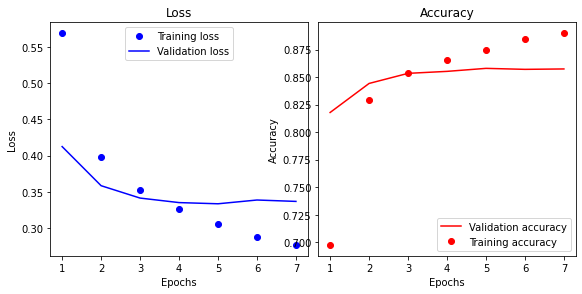

In [46]:
history_dict = history_LSTM.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend(loc='upper center')
plt.tight_layout()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [47]:
model_cnn.evaluate(X_test,  y_test, verbose=2)
model_GMP.evaluate(X_test,  y_test, verbose=2)
model_lstm.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3715 - accuracy: 0.8434
1537/1537 - 2s - loss: 0.4490 - accuracy: 0.7899
1537/1537 - 3s - loss: 0.3442 - accuracy: 0.8528


[0.3442073464393616, 0.8527575135231018]

# 10. 회고

- 1-D CNN, GlobalMaxPooling1D, LSTM 모델 중 **LSTM 모델**이 제일 좋은 성능을 보임
- 한국어 Word2Vec 임베딩 사용 전과 후 test accuracy를 보면 향상된 것을 볼 수 있음 
- 수치가 많이 오르지는 않았지만 결과물을 보면 큰 차이를 보임 
- 키워드 '액션'으로 했을 때 연관된 단어가 잘 나오는 것을 볼 수 있음
- 수치로는 얼마 차이가 안나는데 연관된 단어로 출력된 것을 보면 차이가 많이 나서 적합한 말뭉치를 선택해야 결과도 잘 나오는 것을 볼 수 있었음
- 시각화한 그래프를 봐도 val_loss 값과 val_acc 값이 좋아진 것을 볼 수 있음